In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
city = '서울'

path = 'Data/Variants/Infected/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files[city]
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,162.0,42.12,3.24
1,2021-04-13,158.0,41.08,3.16
2,2021-04-14,247.0,64.22,4.94
3,2021-04-15,217.0,56.42,4.34
4,2021-04-16,216.0,56.16,4.32
...,...,...,...,...
121,2021-08-11,660.0,6.60,627.00
122,2021-08-12,526.0,5.26,499.70
123,2021-08-13,524.0,5.24,497.80
124,2021-08-14,513.0,5.13,487.35


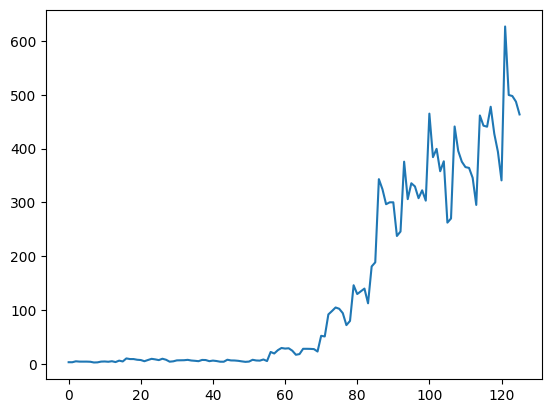

In [3]:
plt.plot(data['delta_variants'])

In [13]:
cities = ['강원', '경기', '경남', '경북', '광주', '대구', 
          '대전', '부산', '서울', '세종', '울산', '인천',
          '전남', '전북', '제주', '충남', '충북']

dic_hyperparameter = {}
for city in cities:
    path = f'hyperparameter/Infected/delta/{city}/*.pkl'
    files = glob.glob(path)
    print(files)
    hyperparameter = {}
    for file in files:
        hyperparameter[file[33:-4]] = load_hyperparameter(file)

    dic_hyperparameter[city] = hyperparameter

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [8]:
city_predicted = {}

for city in cities:
    
    dic_model = load_model_multiple(dic_hyperparameter, 'Infected', 'delta', city)
    data = dic_files[city]
    df = Prepare_df.processing(data, 'stdDay', 'delta_variants')

    x = df.iloc[:, 0:]
    y = df.iloc[:,:1]

    ms = MinMaxScaler()
    ss = StandardScaler()

    ss.fit(x)
    ms.fit(y)

    predicted_values = {}
    num_model = 0
    for name, state in dic_model.items():
        batch_size = 64
        if num_model < 6:
            x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 57, 60, 1, batch_size, 'mto')
            label_y, predicted = predict_mto(state, df, x_ss, y_ms)
            predicted_values[name] = [label_y, predicted]
        else:
            x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 51, 60, 7, batch_size, 'mtm')
            label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
            predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]

        num_model += 1
        
    city_predicted[city] = predicted_values

KeyError: 'RNN'

광주 : 86.10995763956396


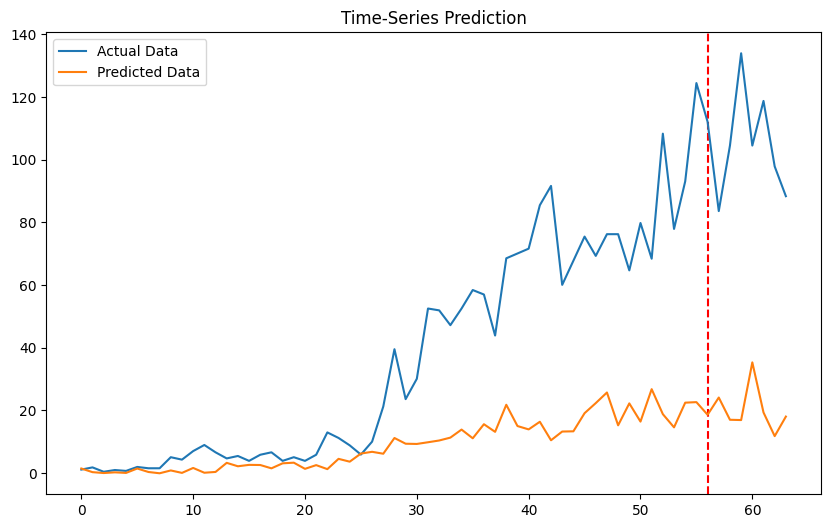

광주 : 82.85468854604729


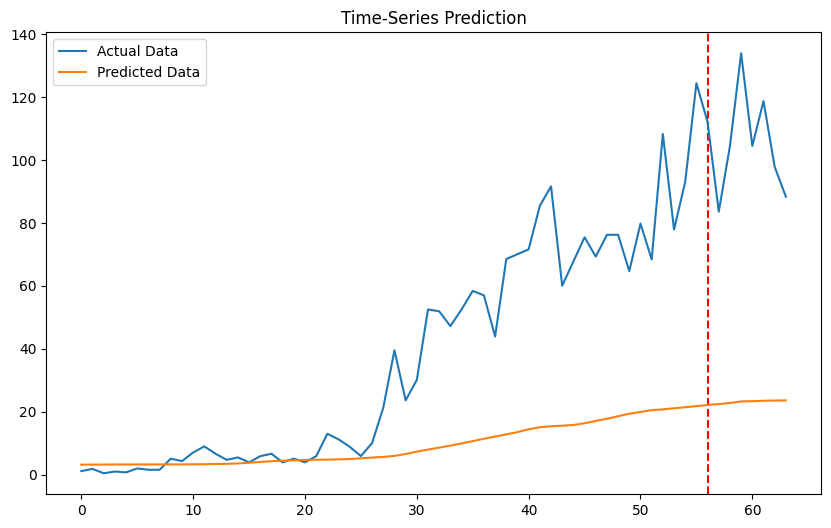

광주 : 74.50997796541246


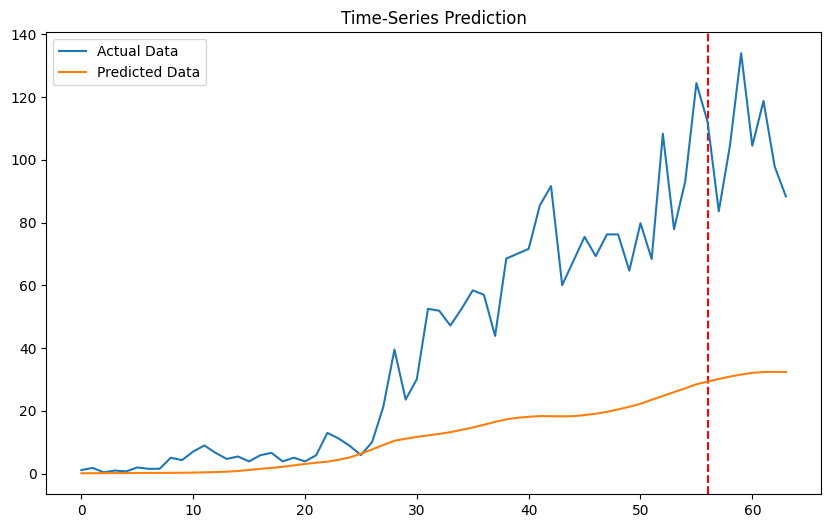

광주 : 81.87391757395179


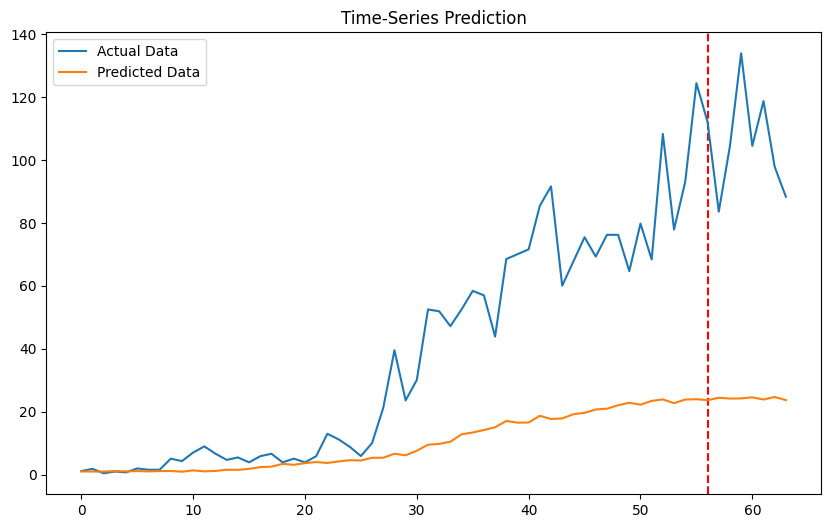

광주 : 72.87791790363354


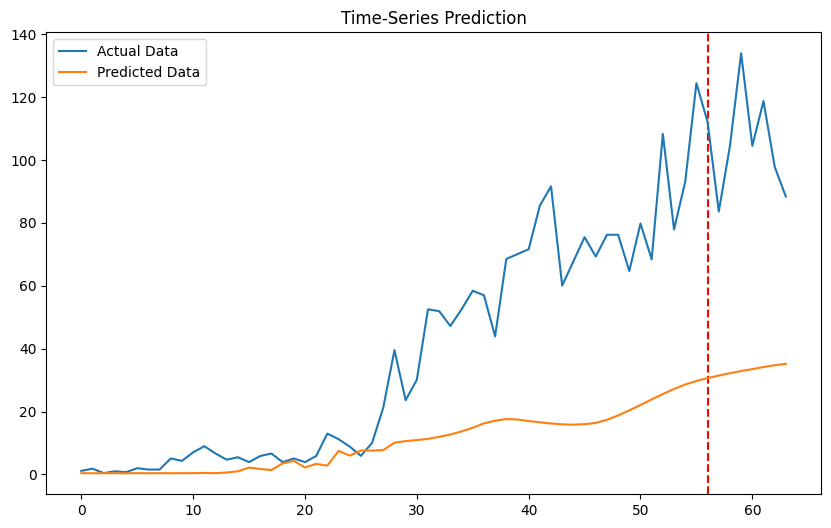

광주 : 84.82544116448791


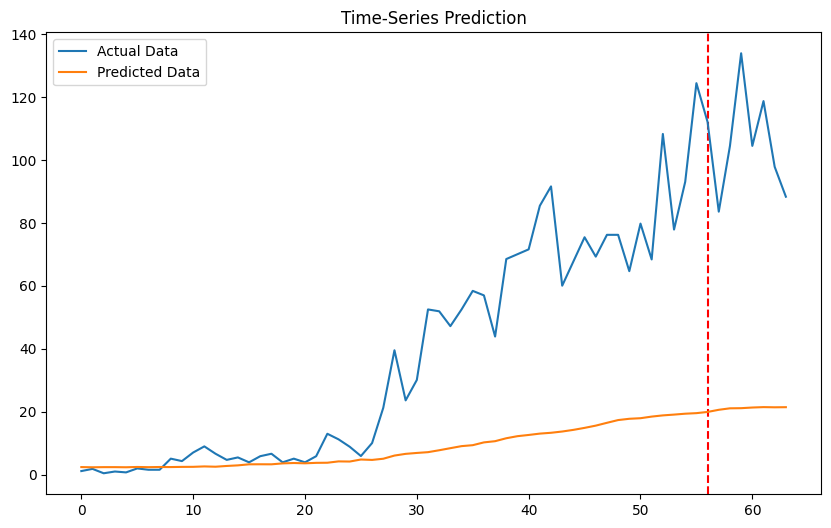

광주 : 88.05112151472007


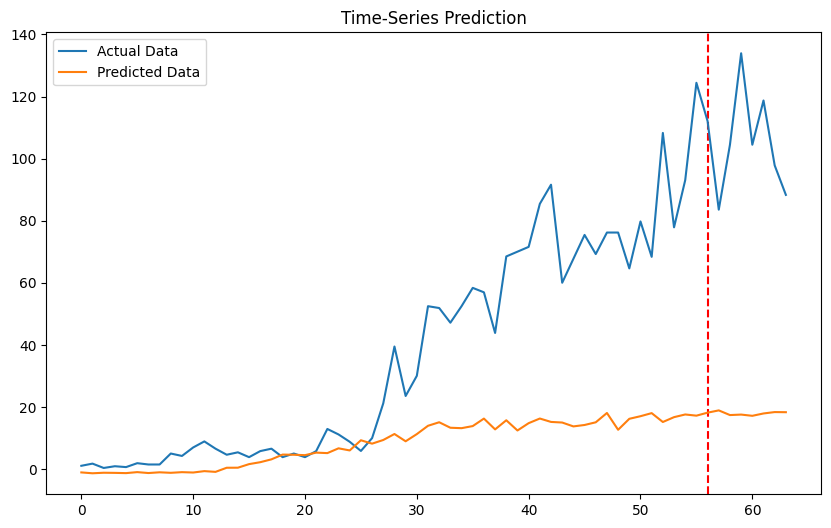

광주 : 84.79154701568135


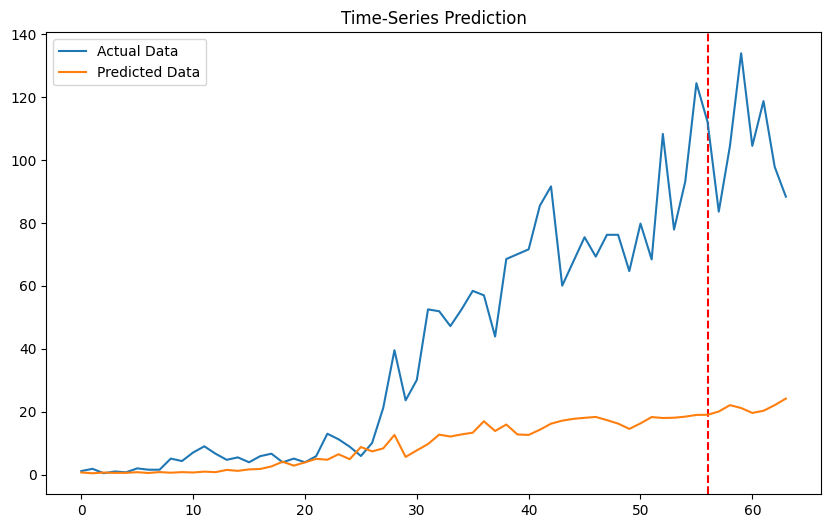

광주 : 85.52105632076085


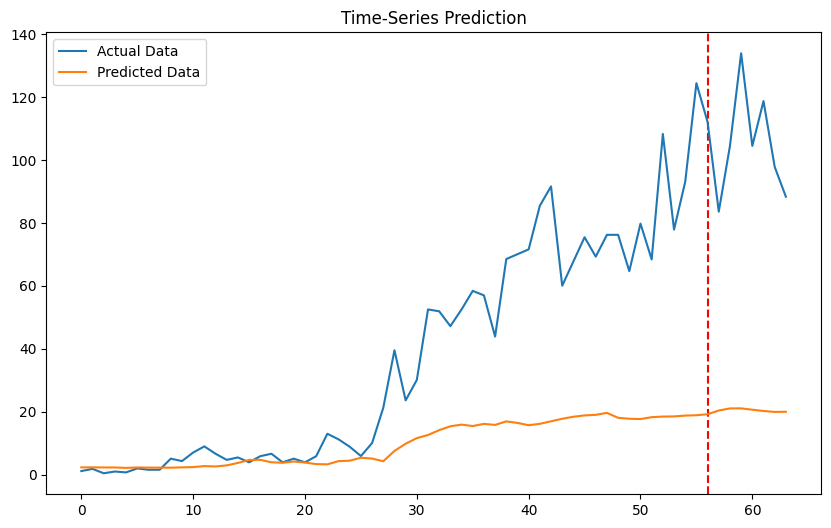

광주 : 87.29463064279784


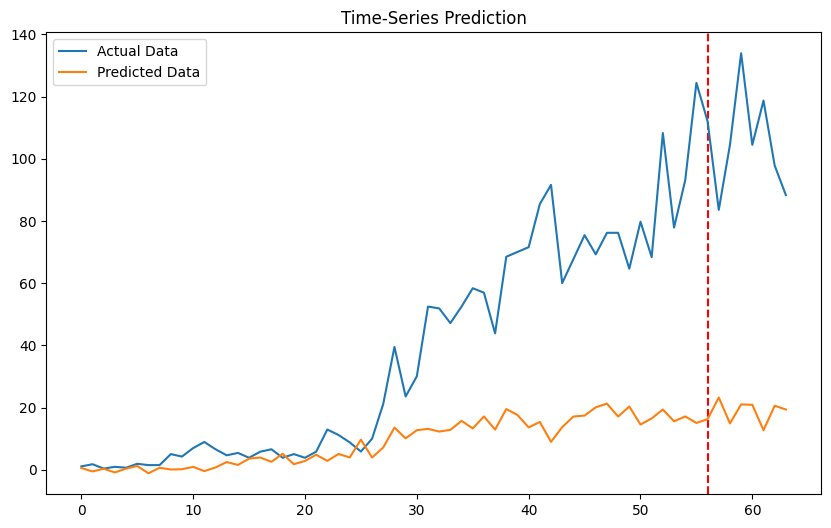

광주 : 88.32709816093389


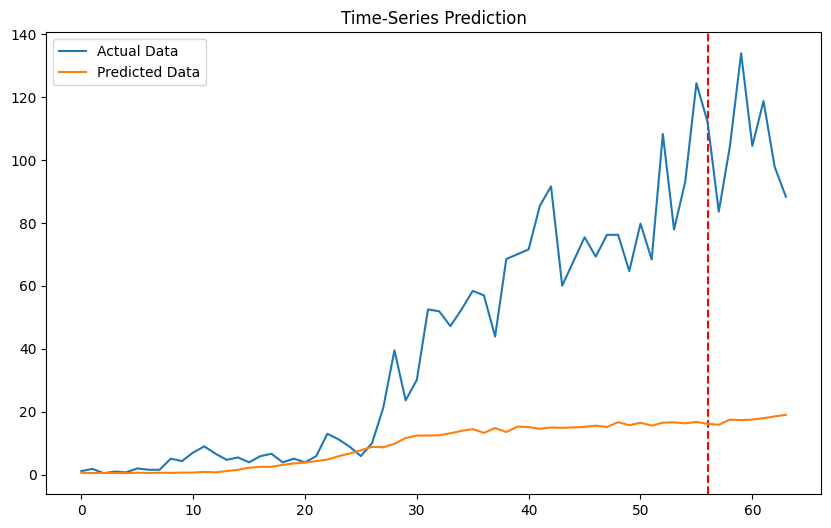

광주 : 89.12486577391716


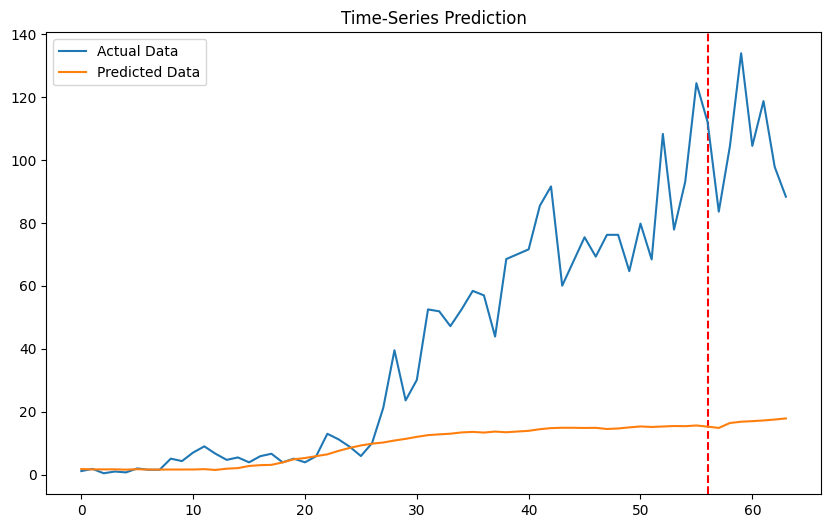

rmse가 가장 적은 모델 :  광주
대구 : 33.736906097148456


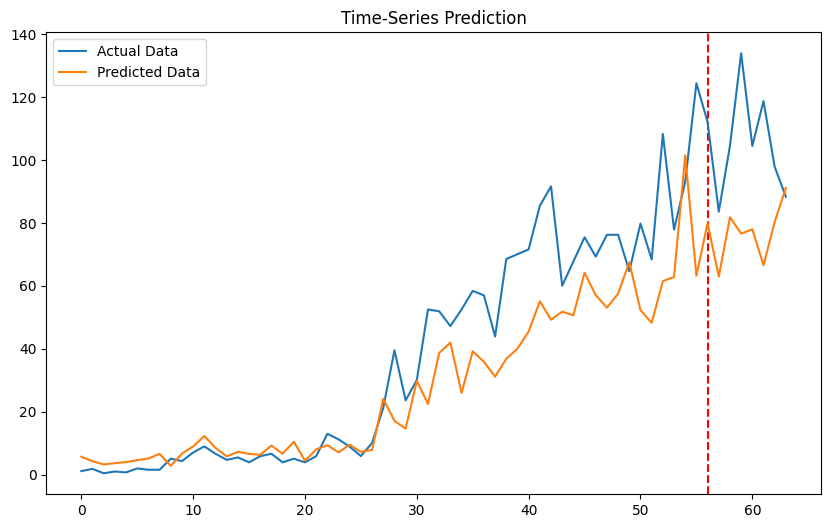

대구 : 25.94053657865005


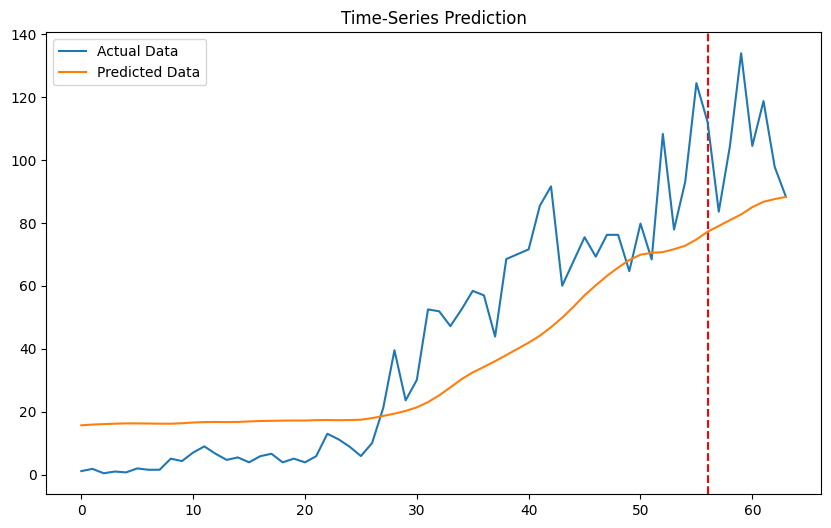

대구 : 17.127215833777445


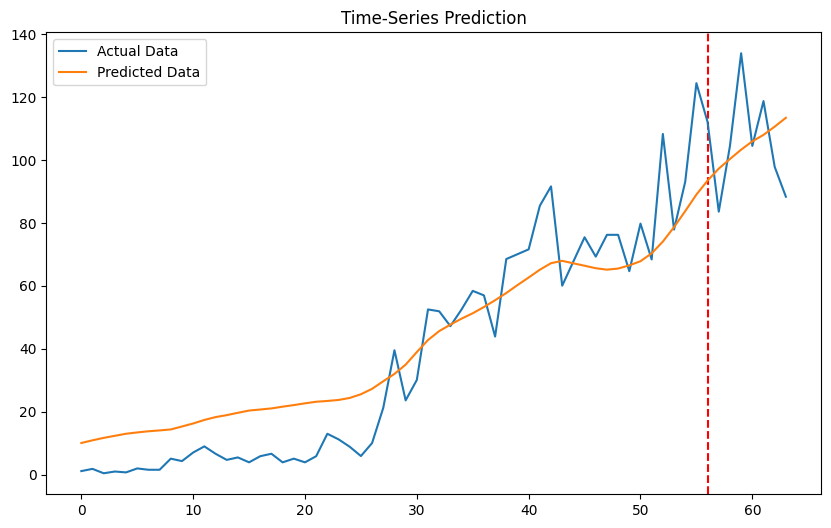

대구 : 21.523073102632207


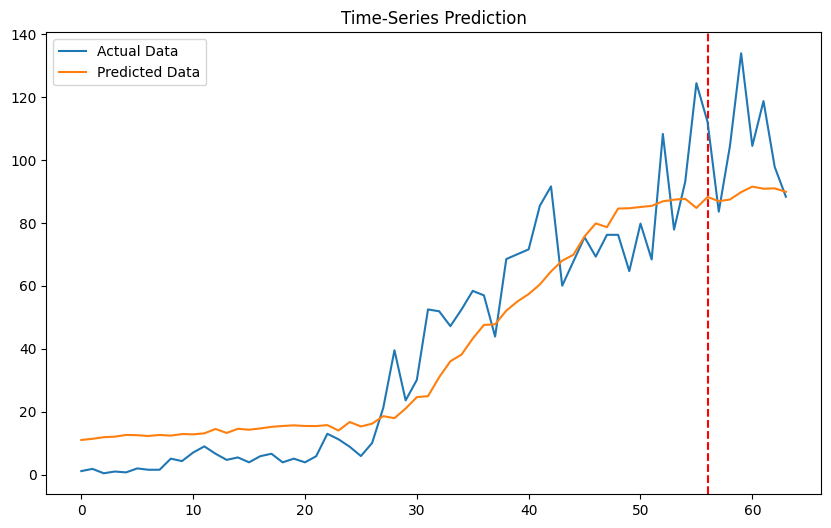

대구 : 23.552094851095518


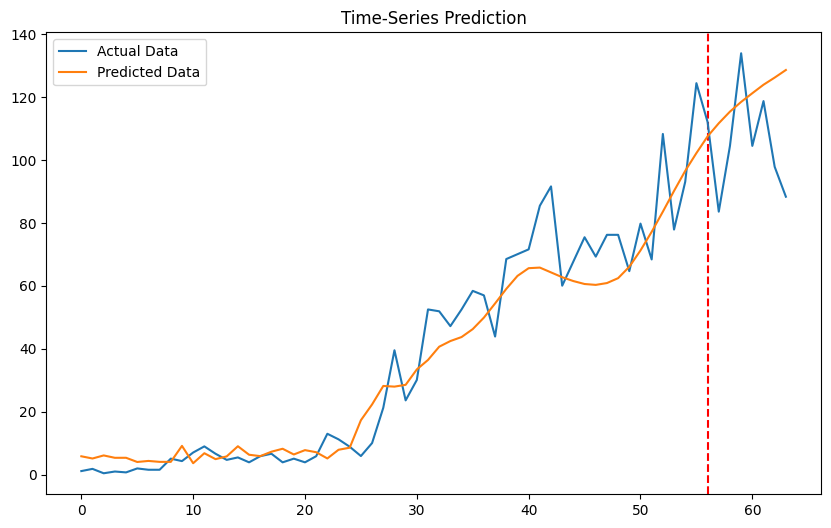

대구 : 29.66107993795805


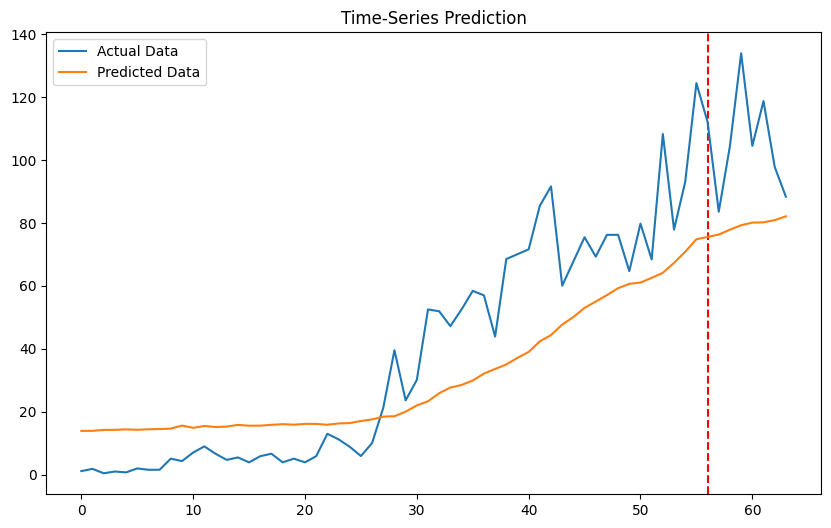

대구 : 37.75518318617823


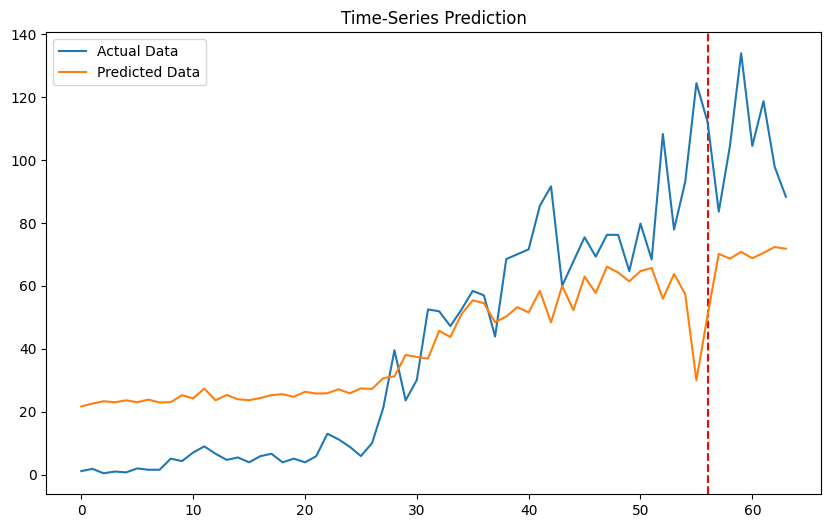

대구 : 36.342384634176625


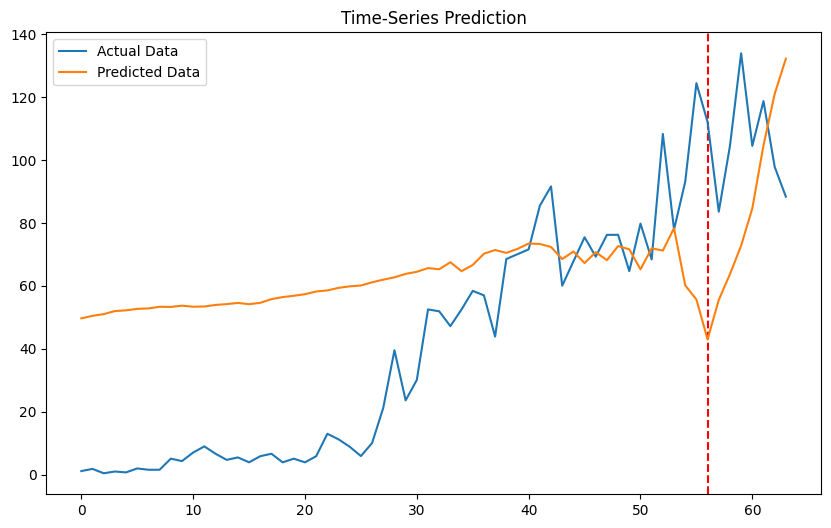

대구 : 37.70722204998086


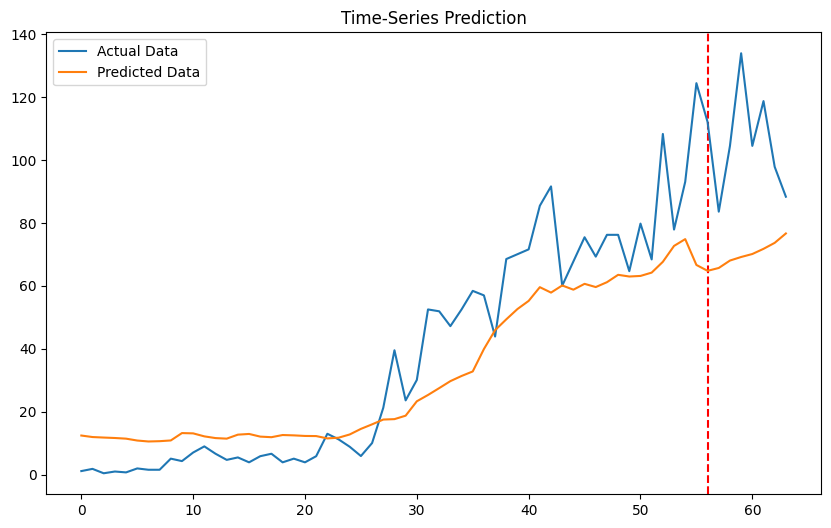

대구 : 36.446010008062785


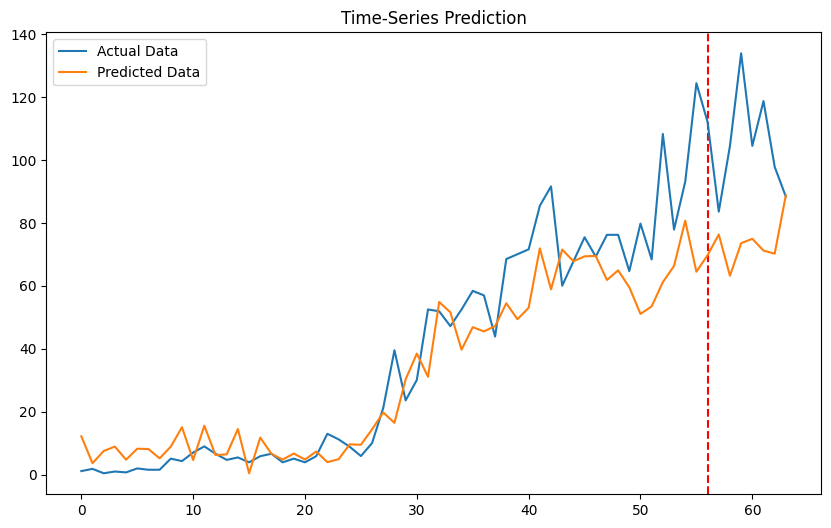

대구 : 38.86815403948971


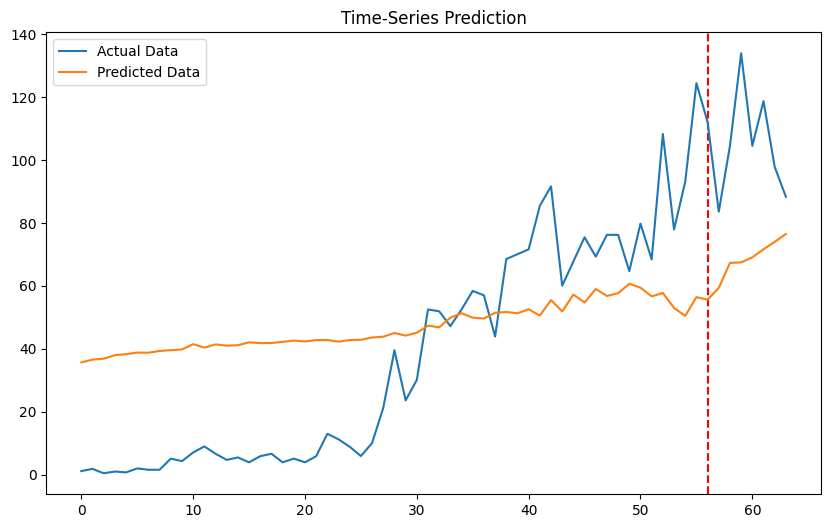

대구 : 36.54659443030397


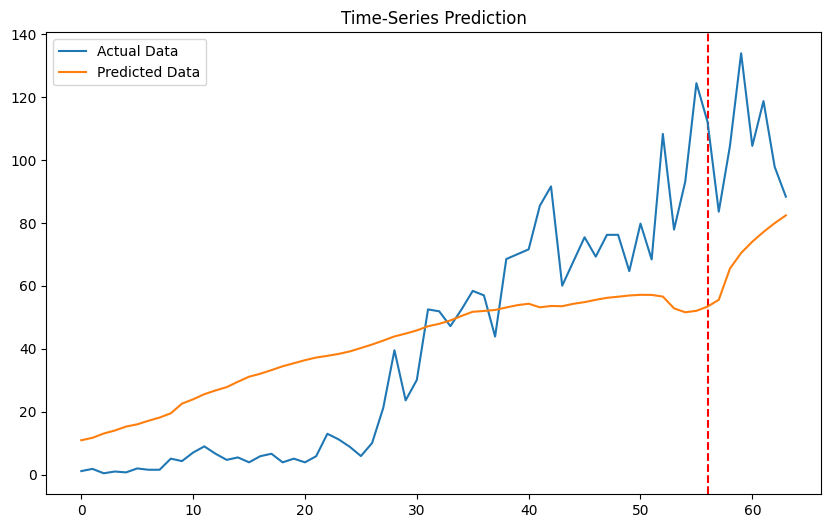

rmse가 가장 적은 모델 :  대구
세종 : 93.58524063988402


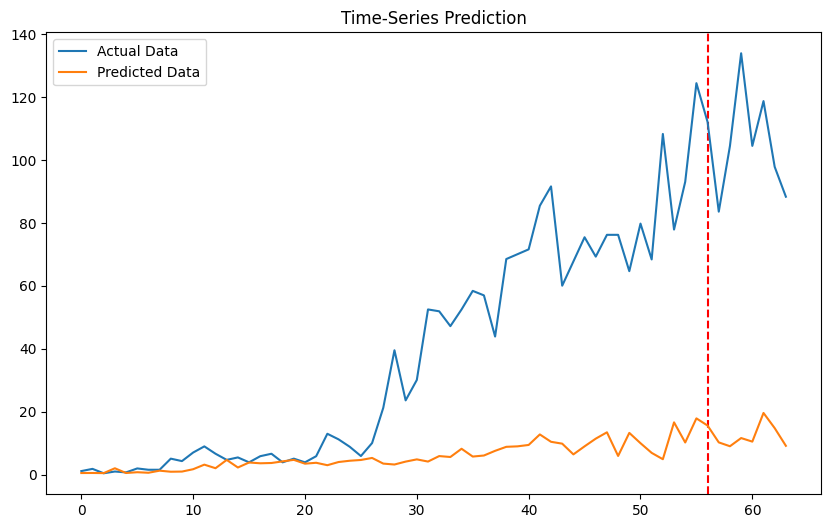

세종 : 92.13512813220319


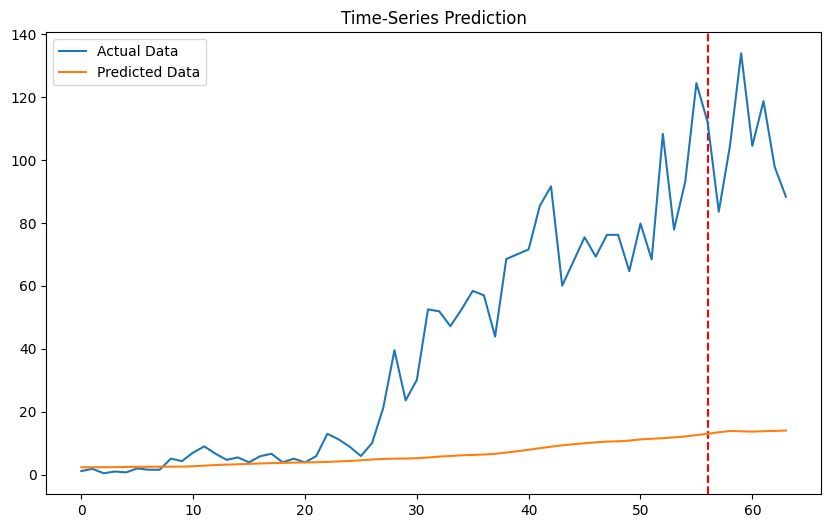

세종 : 87.84228253843646


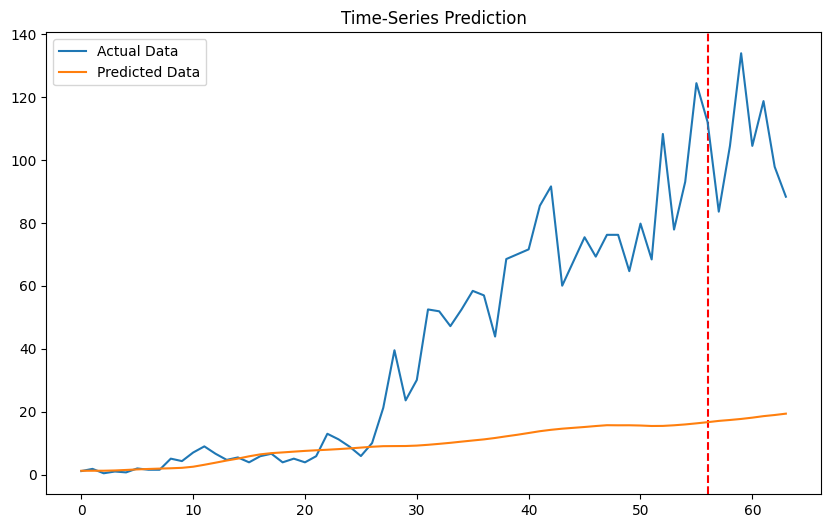

세종 : 91.4475173938582


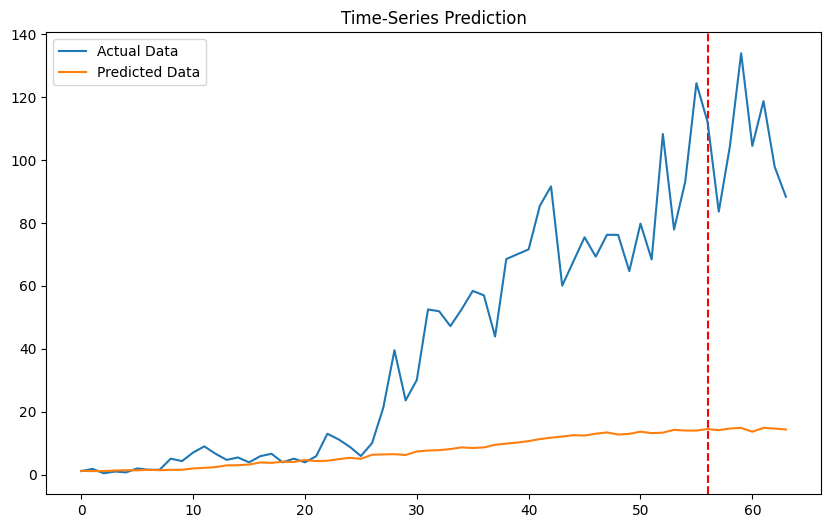

세종 : 83.71156417462583


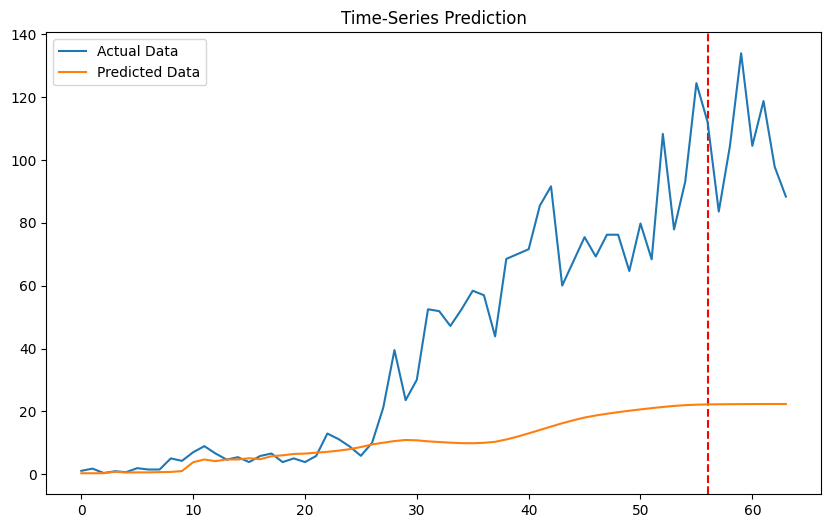

세종 : 93.47658567958342


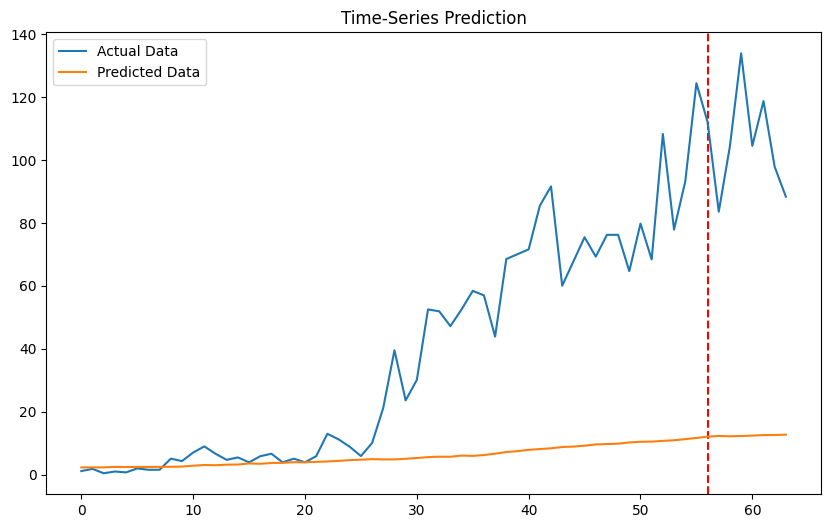

세종 : 95.46283737828297


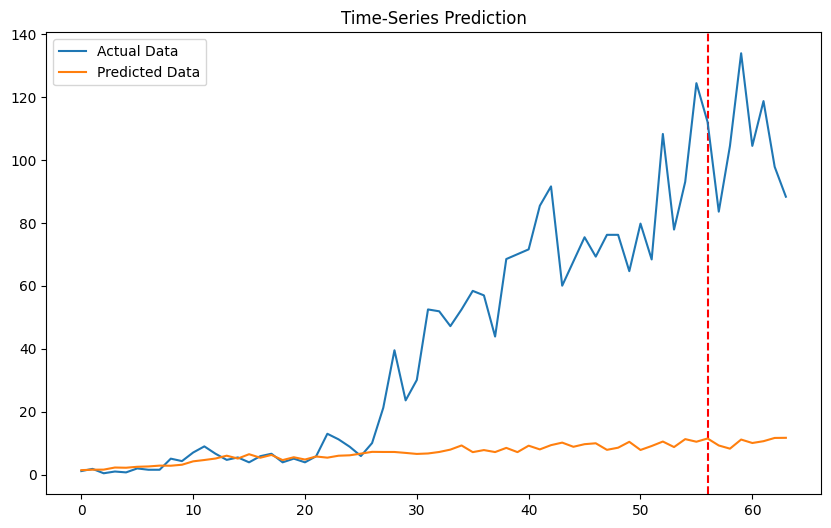

세종 : 91.22331587579461


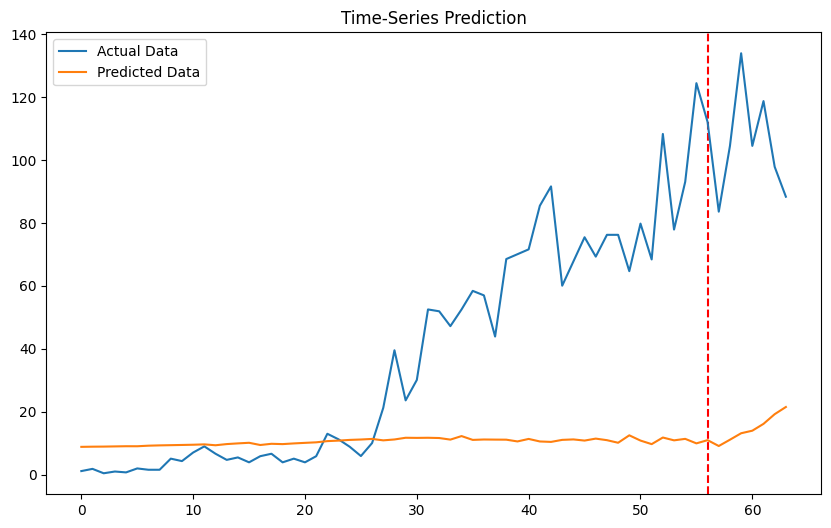

세종 : 96.29229488742855


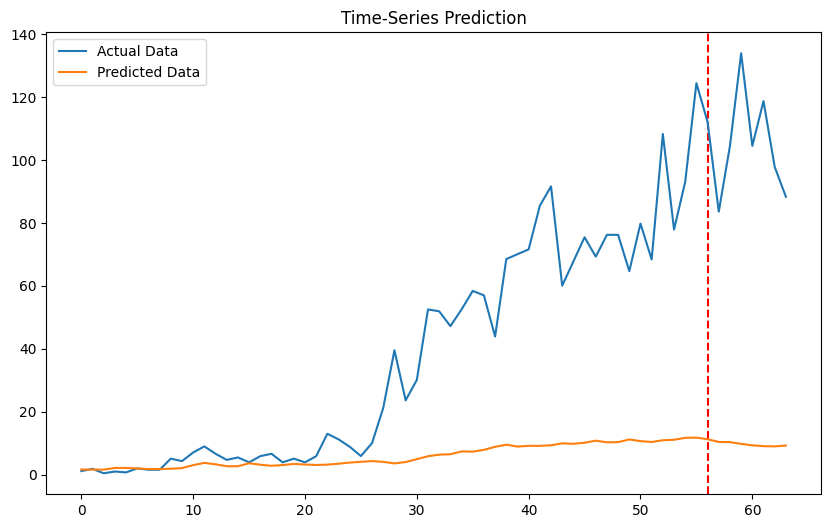

세종 : 95.57557444079266


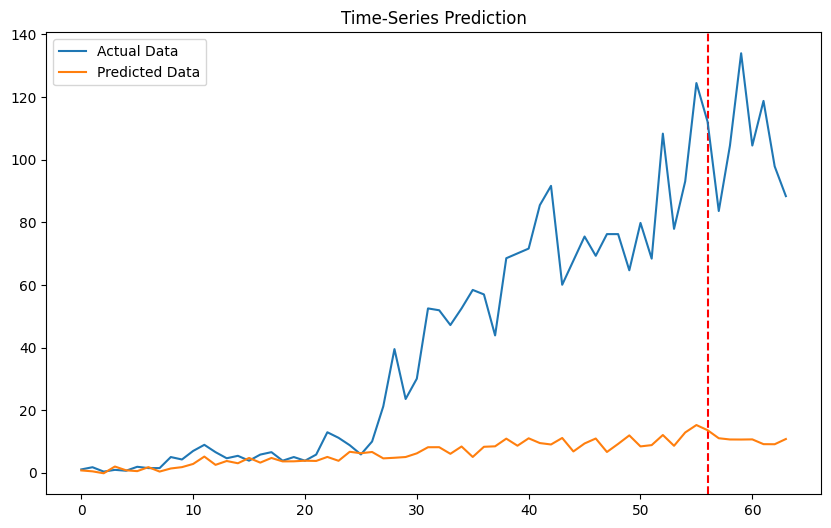

세종 : 95.49717252849689


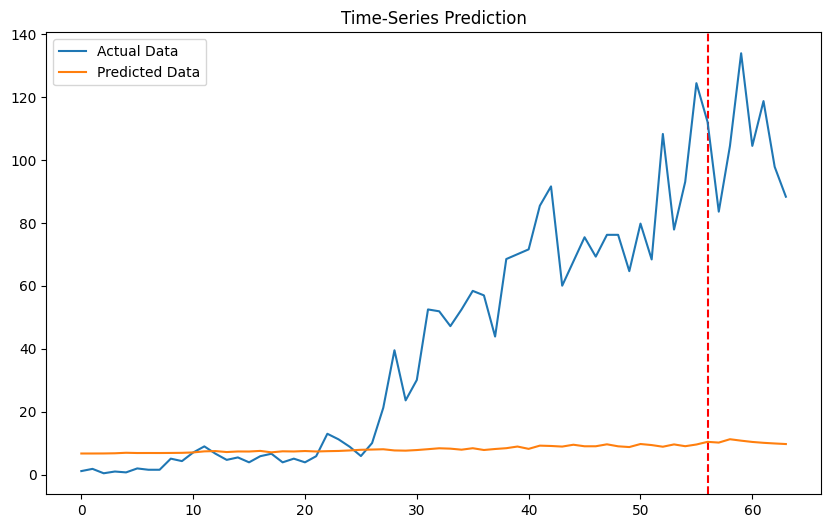

세종 : 95.40418233920617


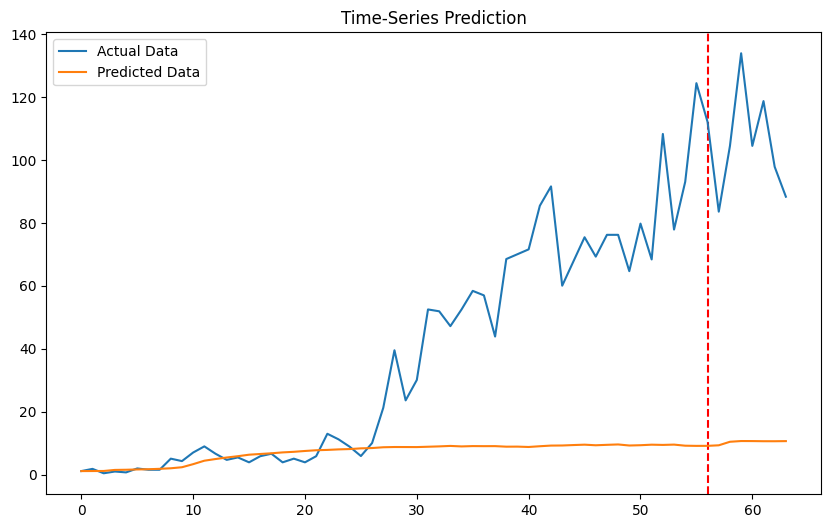

rmse가 가장 적은 모델 :  세종
경기 : 358.92515323532285


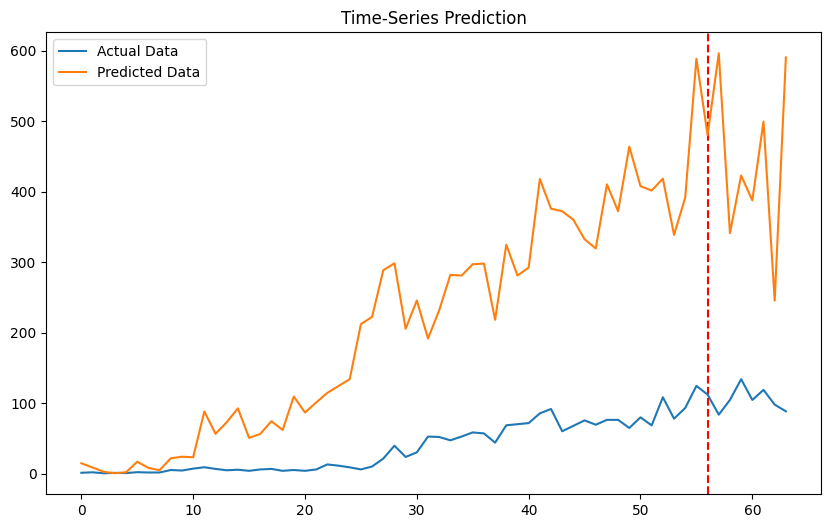

경기 : 386.1455764993301


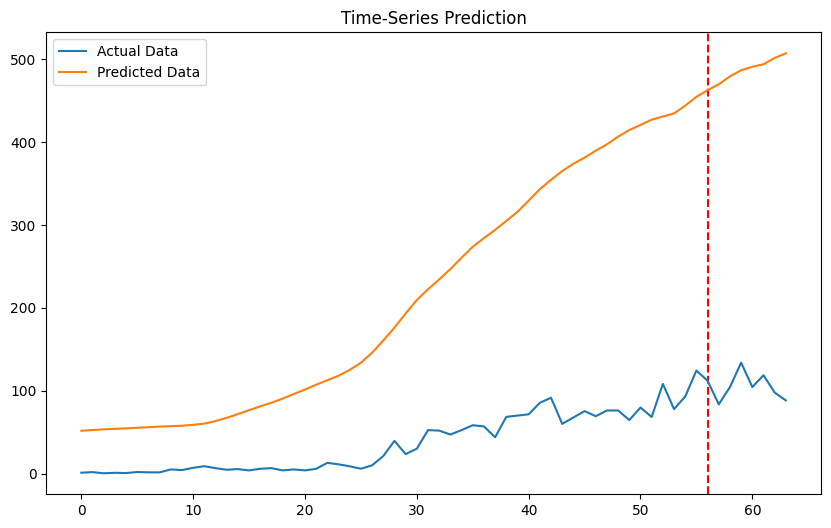

경기 : 558.3177018956143


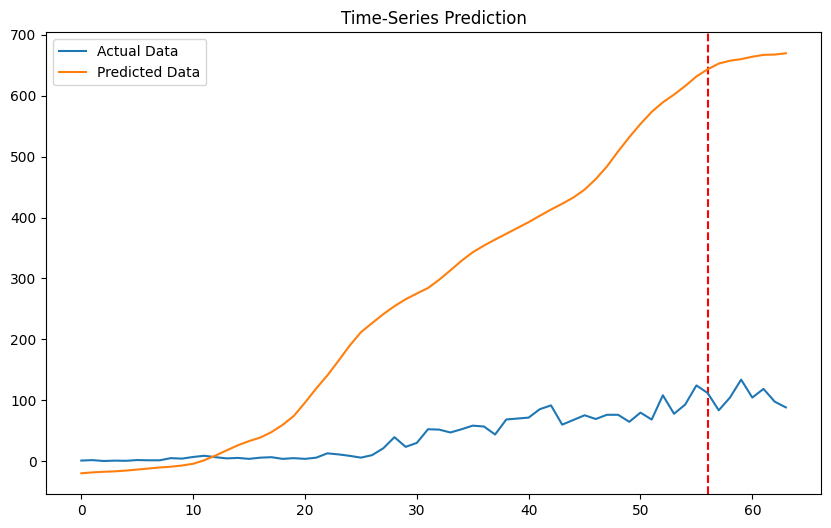

경기 : 407.32419520573535


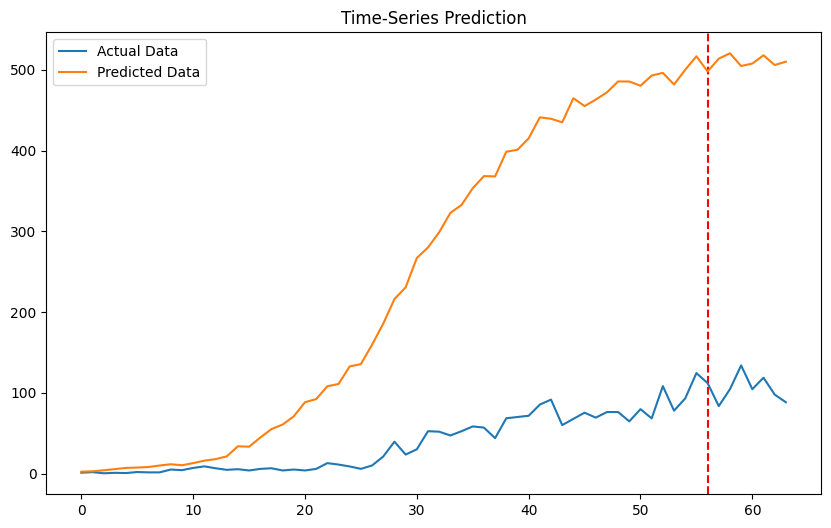

경기 : 627.142477830995


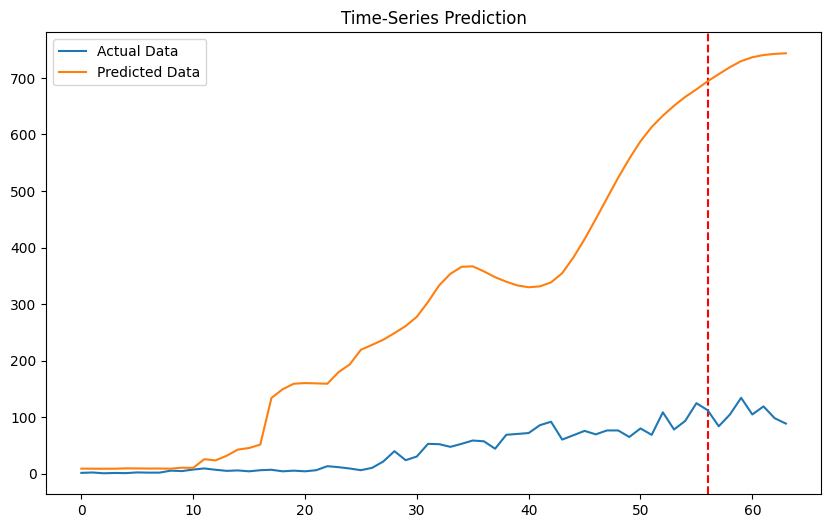

경기 : 352.62559819162306


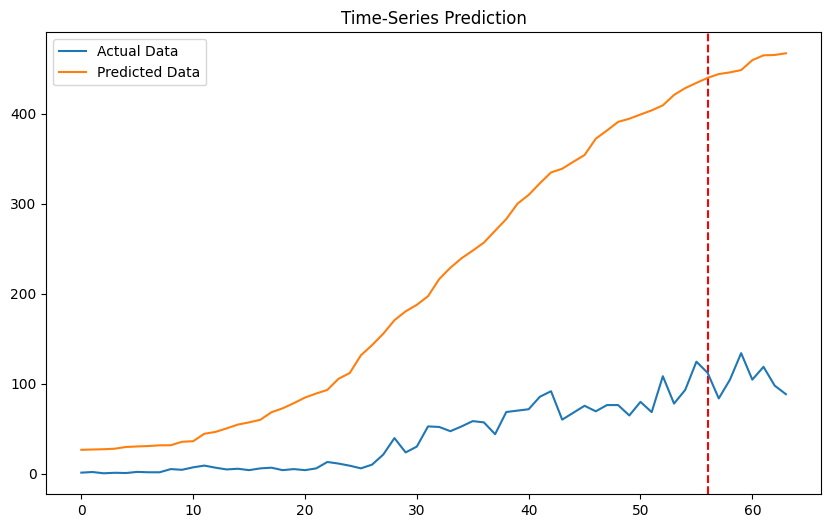

경기 : 286.6865394032304


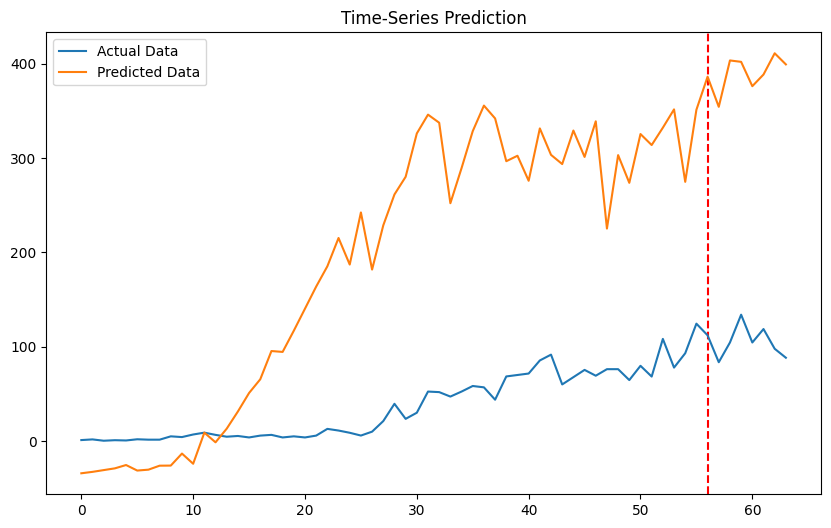

경기 : 464.2986310016432


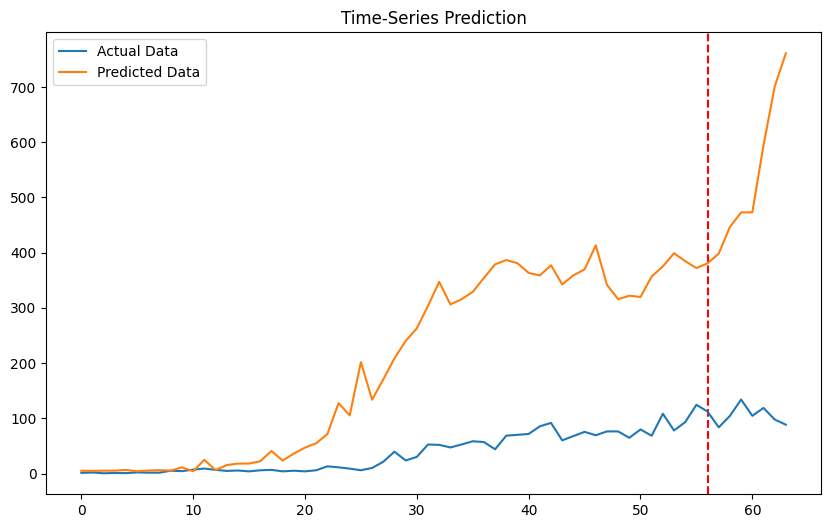

경기 : 325.33503164046135


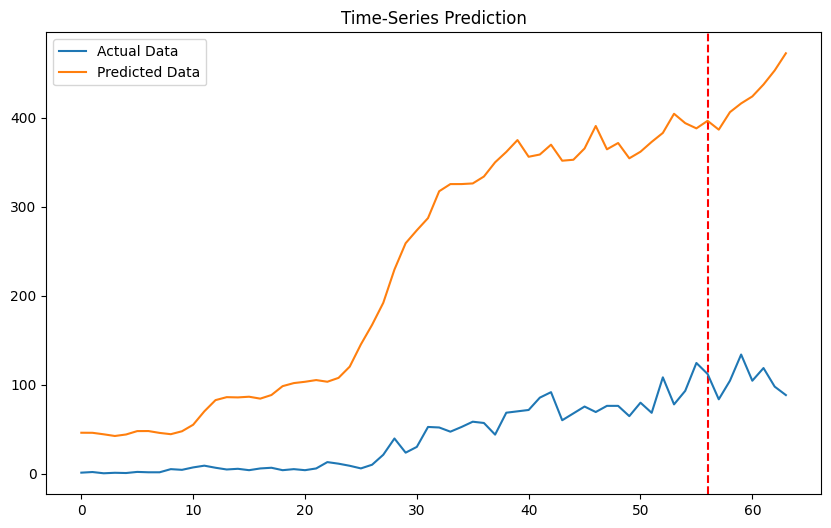

경기 : 299.76093339109417


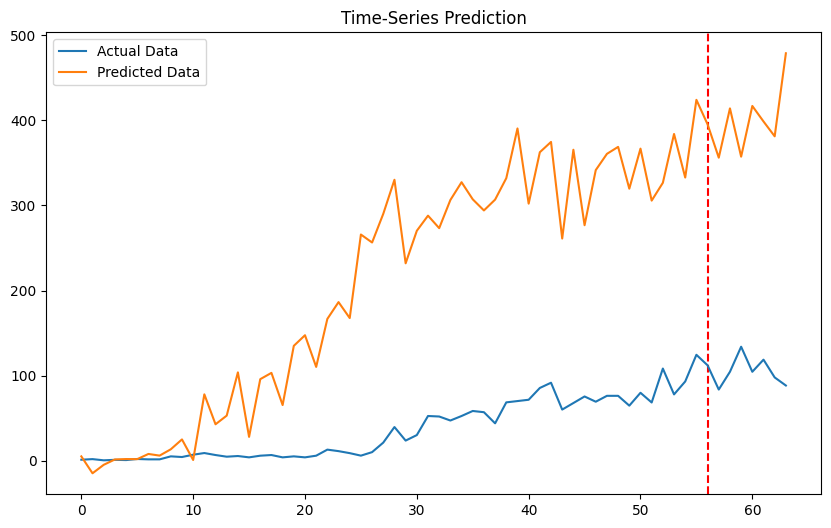

경기 : 314.96961659023555


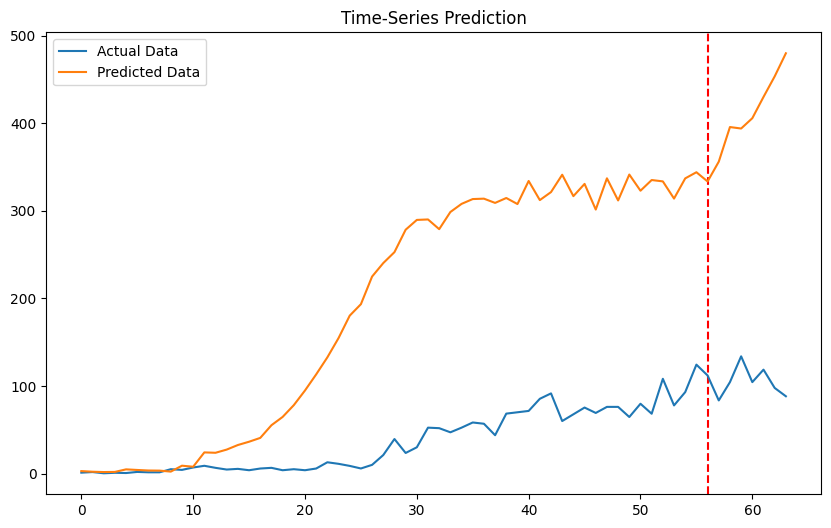

경기 : 304.6928781576622


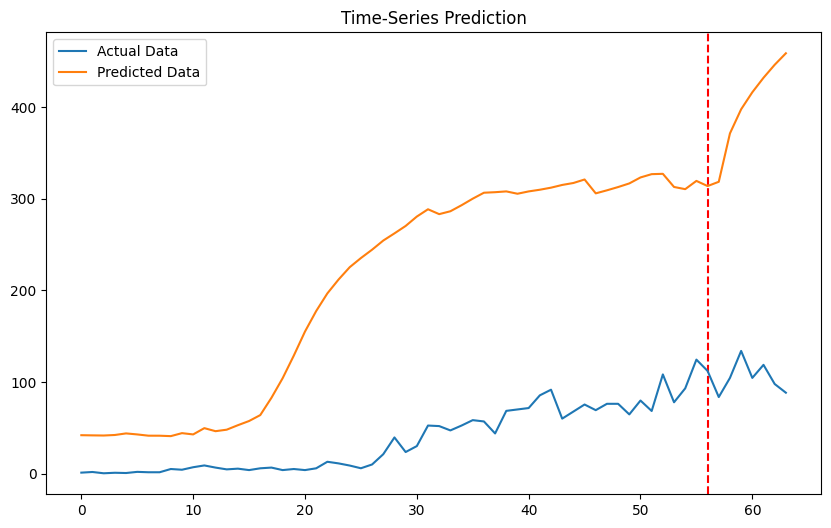

rmse가 가장 적은 모델 :  경기
경남 : 20.79876567405992


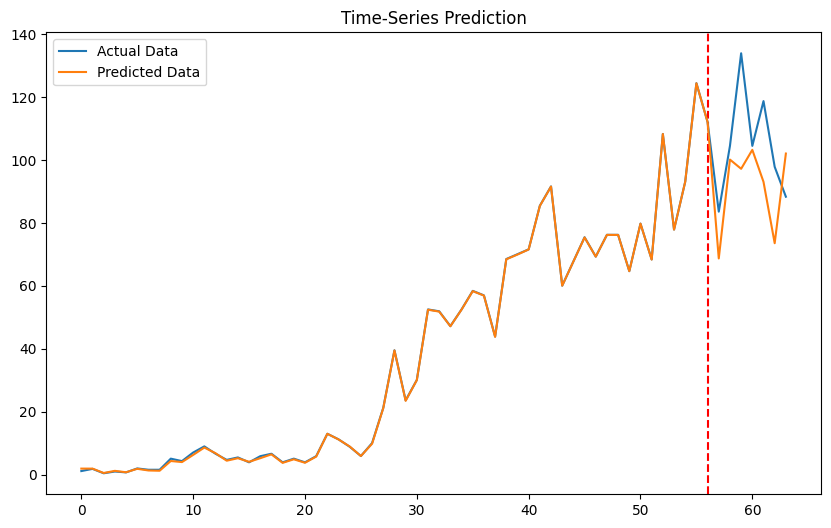

경남 : 16.493941610884928


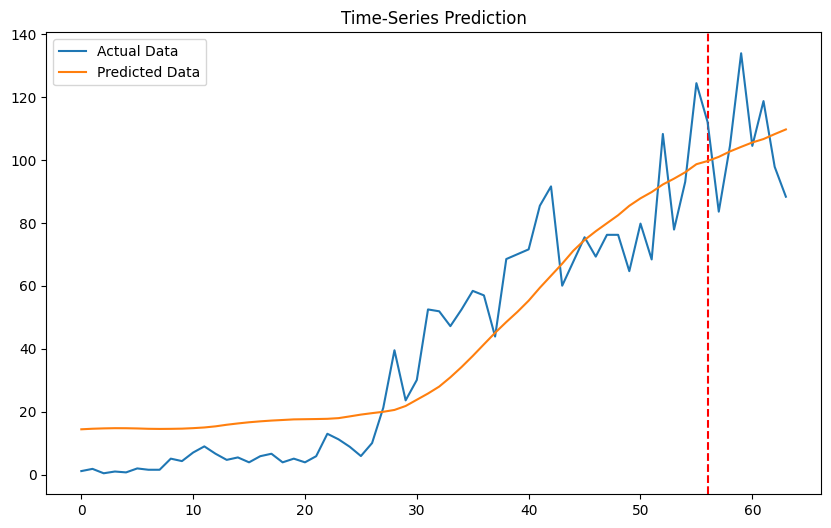

경남 : 34.44426260732693


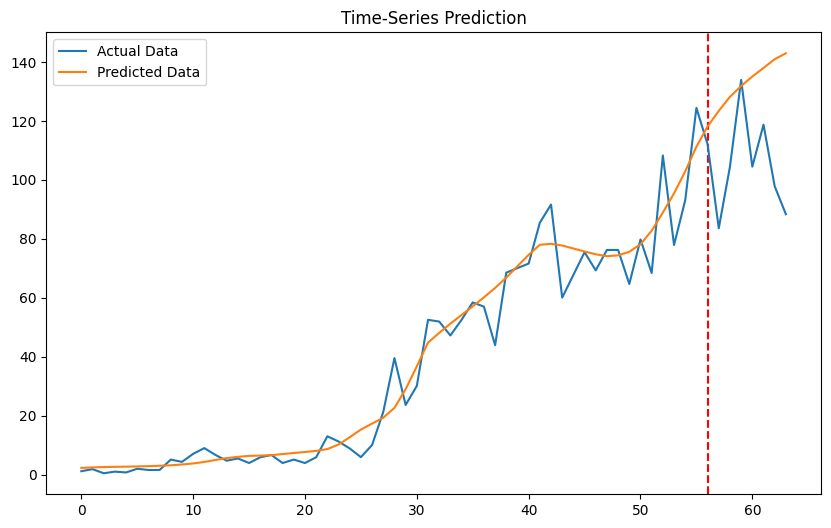

경남 : 15.722764460031353


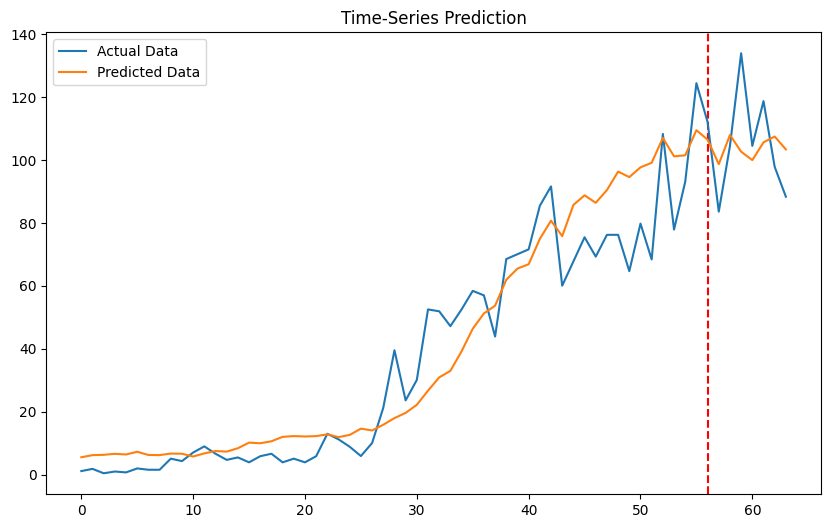

경남 : 36.16059995710542


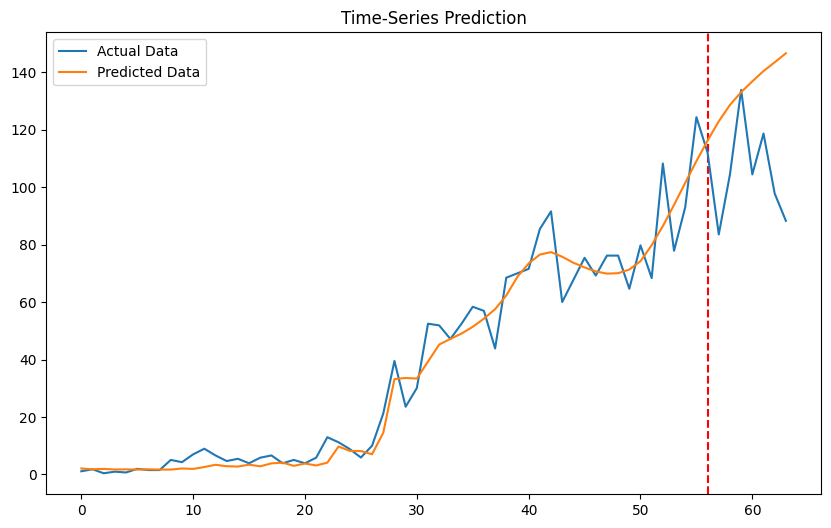

경남 : 17.58700296639094


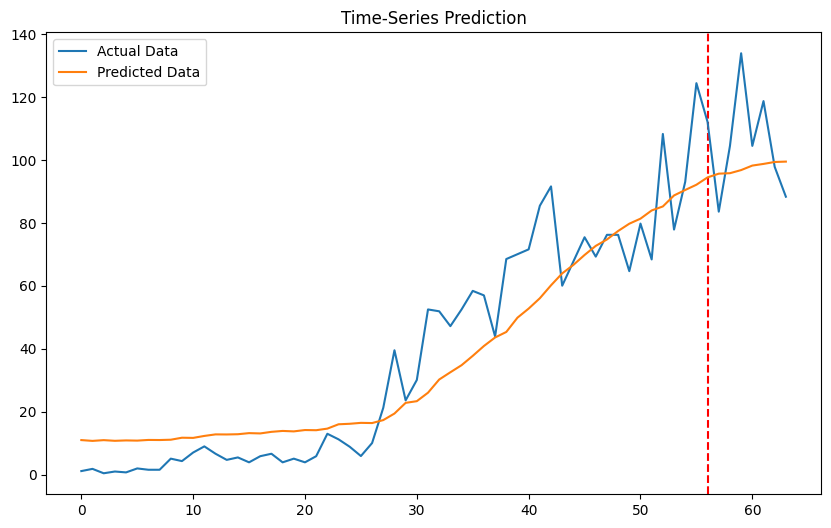

경남 : 33.599094778310246


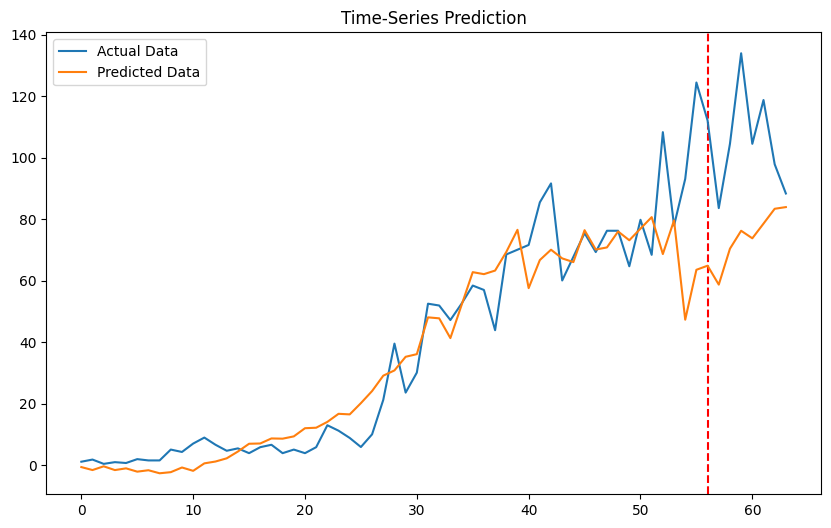

경남 : 37.14396249991797


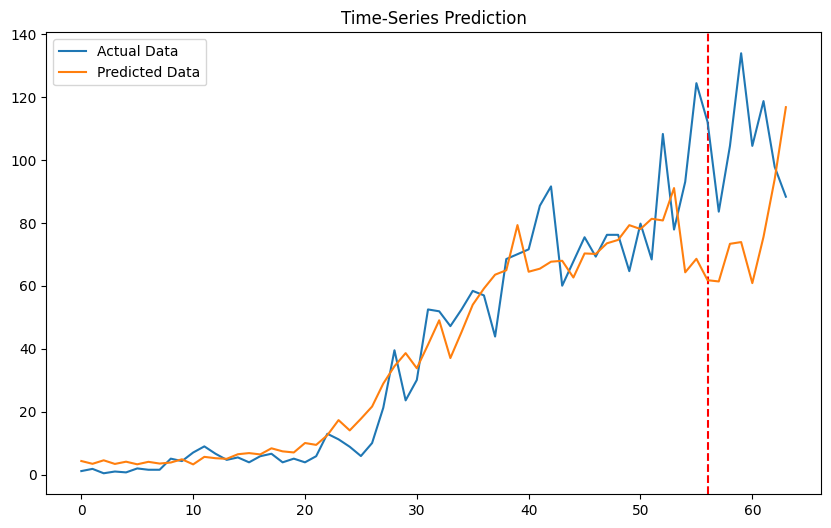

경남 : 34.66903893594669


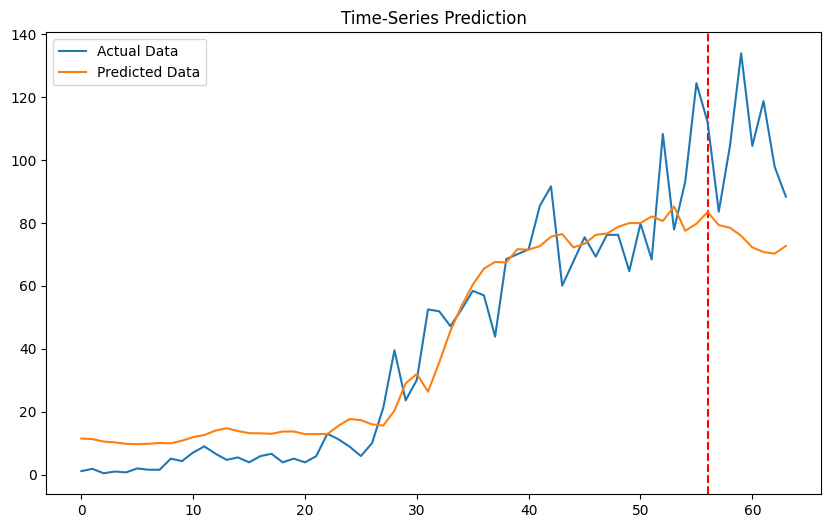

경남 : 35.82980977558613


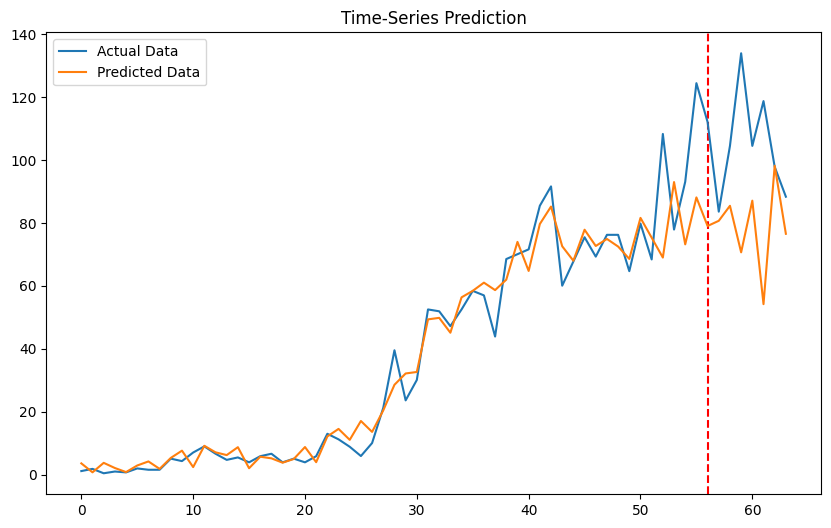

경남 : 34.08085980257559


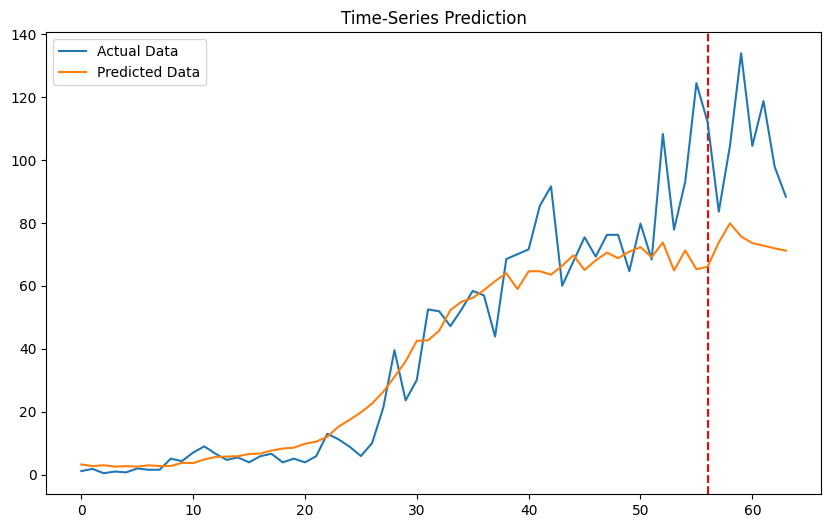

경남 : 38.25926345650652


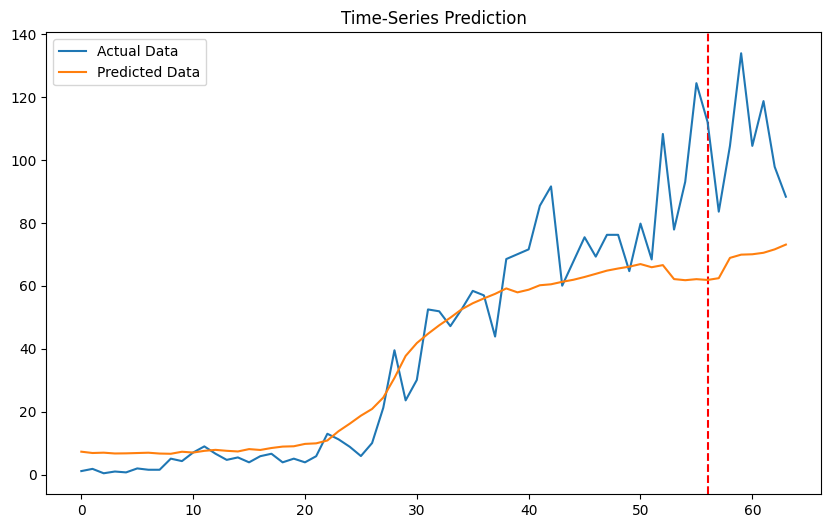

rmse가 가장 적은 모델 :  경남


In [10]:
dic_best_model = {}

for city in cities:
    
    actual_data = city_predicted[city]['RNN'][0]
    rmse_min = np.inf
    num_model = 0

    for name, file in city_predicted[city].items():
        if num_model < 6:
            predicted_data = file[1]
        else:
            predicted_data = file[4]

        rmse_val = rmse(actual_data[-7:], predicted_data[-7:])
        if rmse_min > rmse_val:
            rmse_min = rmse_val
            best_model = name
            best_actual = actual_data
            best_predicted = predicted_data

        #print(city + ' :', rmse_val)
        #plotting(actual_data, predicted_data, 56)

        num_model += 1
    
    dic_best_model[city] = [best_model, rmse_val, best_actual, best_predicted]
    
    print(f'rmse가 가장 적은 모델 : {city}', best_model)
    df_predicted = pd.DataFrame()
    df_predicted = pd.DataFrame(np.concatenate([best_actual, best_predicted], axis = 1), columns = ['Alpha_origin', 'Alpha_Predicted'])
    df_predicted.index = list(data['stdDay'][-1*len(best_actual):])
    df_predicted.to_csv(f'Data/Predicted/Variants/Infected/{city}/alpha_{best_model}.csv')

In [ ]:
for city in cities:
    print(f'{city} best model : {dic_best_model[city][0]}')
    print(f'rmse : {dic_best_model[city][1]}')
    plotting(dic_best_model[city][2], dic_best_model[city][3], 56)